<a href="https://colab.research.google.com/github/ibacaraujo/learning-pytorch/blob/master/what_is_torch_nn_really.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is torch.nn really?

PyTorch provides the elegantly designed modules and classes torch.nn, torch.optim, Dataset and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from torch.nn, torch.optim, Dataset, or DataLoader at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible

## MNIST data setup

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, 
                                                            encoding="latin-1")

(50000, 784)


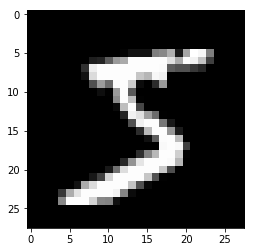

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

In [9]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5348, -2.2768, -2.2363, -2.2195, -2.7000, -2.3980, -2.3821, -1.7264,
        -2.7322, -2.2150], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [0]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [13]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3379, grad_fn=<NegBackward>)


In [0]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [15]:
print(accuracy(preds, yb))

tensor(0.1406)


In [0]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            #set_trace()
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [30]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0827, grad_fn=<NegBackward>) tensor(1.)
